In [1]:
import pandas as pd
import time
import gc
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import xgboost
from sklearn.ensemble import RandomForestRegressor
import warnings
from itertools import product
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.linear_model import Ridge, Lasso
from optuna import create_study
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

C:\Users\79826\anaconda3\envs\ds\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_sales = pd.read_csv('sales_train.csv')
train_sales.shape

(2935849, 6)

In [3]:
train_sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [4]:
a = train_sales['date']

In [5]:
gr = train_sales.groupby('date_block_num')['item_cnt_day'].sum()

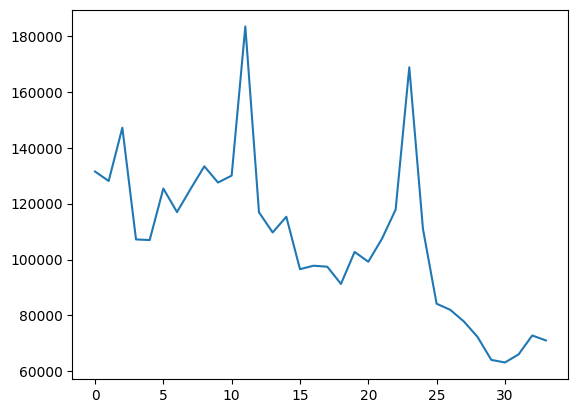

In [6]:
plt.plot(gr.index, gr.values)

In [7]:
train_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [8]:
test = pd.read_csv('test.csv')
test.shape

(214200, 3)

In [9]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [10]:
items = pd.read_csv('items.csv')

In [11]:
print(items.shape)
items.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
item_cat = pd.read_csv('item_categories.csv')

In [13]:
print(item_cat.shape)
item_cat.head()

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [14]:
shops = pd.read_csv('shops.csv')

In [15]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [16]:
shops.loc[[0, 1], 'shop_name'] = shops.loc[[0, 1], 'shop_name'].apply(lambda x: x[1:])

In [17]:
shops['city'] = pd.factorize(shops['shop_name'].apply(lambda x: x.split()[0]))[0]
shops = shops[['city', 'shop_id']]

<AxesSubplot: xlabel='item_cnt_day', ylabel='Density'>

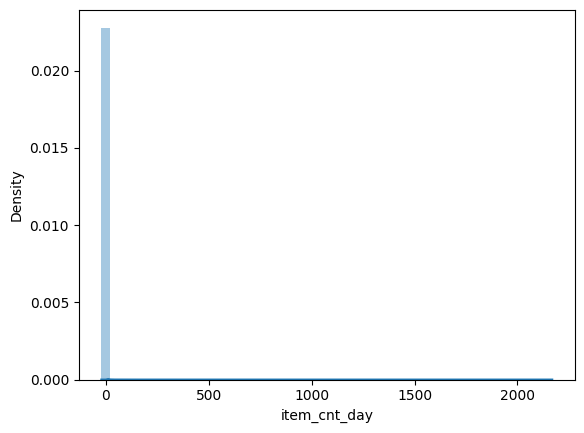

In [18]:
sns.distplot(train_sales['item_cnt_day'])

<AxesSubplot: >

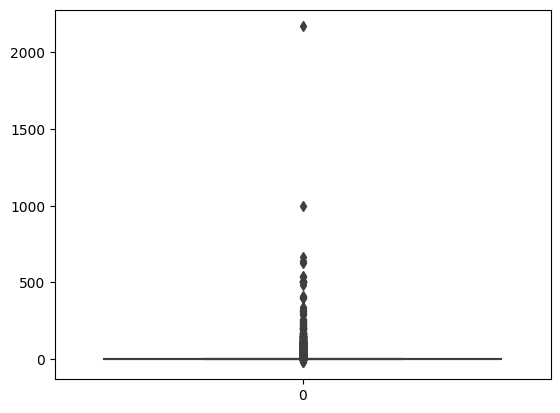

In [19]:
sns.boxplot(train_sales['item_cnt_day'])

<AxesSubplot: >

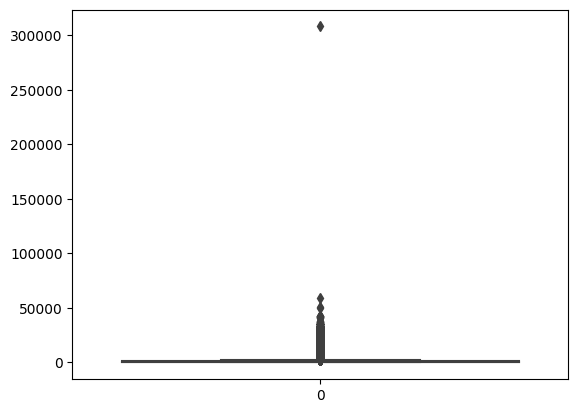

In [20]:
sns.boxplot(train_sales['item_price'])

In [21]:
train_sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [22]:
train_sales[train_sales['item_cnt_day'] > 900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [23]:
items[items['item_id'] == 11373]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


In [24]:
items[items['item_id'] == 20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


In [25]:
train_sales[train_sales['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [26]:
train_sales.drop(train_sales[train_sales['item_cnt_day'] > 1010].index, inplace=True)

In [27]:
train_sales[train_sales['item_price'] > 100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [28]:
items[items['item_id'] == 6066]['item_name']

6066    Radmin 3  - 522 лиц.
Name: item_name, dtype: object

In [29]:
train_sales.drop(train_sales[(train_sales['item_price'] > 100000) & (train_sales['item_price'] < 0)].index, inplace=True)

In [30]:
train_sales.loc[train_sales.shop_id == 0, 'shop_id'] = 57
train_sales.loc[train_sales.shop_id == 1, 'shop_id'] = 58
train_sales.loc[train_sales.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [31]:
train = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train_sales[train_sales.date_block_num==i]
    train.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

In [32]:
train = pd.DataFrame(np.vstack(train), columns=cols)

In [33]:
print(train.shape)
train.head()

(10913850, 3)


,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [34]:
train_sales['sum'] = train_sales['item_cnt_day'] * train_sales['item_price']

In [35]:
group = train_sales.groupby(['date_block_num', 'shop_id', 'item_id'])[['item_cnt_day', 'sum']].sum().reset_index()

In [36]:
trains_ind = train.shape[0]

In [37]:
test.insert(0, 'date_block_num', 34)

In [38]:
test_id = test['ID']
test.drop('ID', 1, inplace=True)

In [39]:
train_test = pd.concat([train, test])
del train, test
gc.collect()

5

In [40]:
train_test = train_test.merge(group, on=['date_block_num', 'shop_id', 'item_id'], how='left')

In [41]:
train_test = train_test.merge(items.drop('item_name', 1), on='item_id', how='left')

In [42]:
train_test = train_test.merge(shops, on='shop_id', how='left')

In [43]:
train_test

,date_block_num,shop_id,item_id,item_cnt_day,sum,item_category_id,city
0,0,59,22154,1.0,999.0,37,30
1,0,59,2552,NaN,NaN,58,30
2,0,59,2554,NaN,NaN,58,30
3,0,59,2555,NaN,NaN,56,30
4,0,59,2564,NaN,NaN,59,30
...,...,...,...,...,...,...,...
11128045,34,45,18454,NaN,NaN,55,21
11128046,34,45,16188,NaN,NaN,64,21
11128047,34,45,15757,NaN,NaN,55,21
11128048,34,45,19648,NaN,NaN,40,21


In [44]:
item_cat['name_cat'] = item_cat['item_category_name'].str.split('-').apply(lambda x: x[0].strip())
item_cat['name_cat'] = pd.factorize(item_cat['name_cat'])[0]
item_cat['name_cat2'] = pd.factorize(item_cat['item_category_name'].apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip()))[0]
item_cat = item_cat[['item_category_id', 'name_cat', 'name_cat2']]
train_test = train_test.merge(item_cat, on='item_category_id', how='left')

In [45]:
train_test.head()

,date_block_num,shop_id,item_id,item_cnt_day,sum,item_category_id,city,name_cat,name_cat2
0,0,59,22154,1.0,999.0,37,30,11,2
1,0,59,2552,NaN,NaN,58,30,13,7
2,0,59,2554,NaN,NaN,58,30,13,7
3,0,59,2555,NaN,NaN,56,30,13,7
4,0,59,2564,NaN,NaN,59,30,13,7


In [46]:
train_test['month'] = train_test['date_block_num'] % 12

In [47]:
train_test.isna().mean()

date_block_num      0.000000
shop_id             0.000000
item_id             0.000000
item_cnt_day        0.855399
sum                 0.855399
item_category_id    0.000000
city                0.000000
name_cat            0.000000
name_cat2           0.000000
month               0.000000
dtype: float64

In [48]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   item_id           int64  
 3   item_cnt_day      float64
 4   sum               float64
 5   item_category_id  int64  
 6   city              int64  
 7   name_cat          int64  
 8   name_cat2         int64  
 9   month             int64  
dtypes: float64(2), int64(8)
memory usage: 933.9 MB


In [49]:
def f(df, lags, col, group_cols, aggfunc, sales=False):
    if sales:
        df1 = train_sales[group_cols + [col]].copy()
    else:
        df1 = df[group_cols + [col]].copy()
    group = df1.groupby(group_cols).agg({col: aggfunc}).reset_index()
    cols = group_cols.copy()
    cols1 = []
    for i in aggfunc:
        cols1 += ['_'.join(group_cols) + '_' + col + '_' + i]
    cols += cols1
    group.columns = cols
    for lag in lags:
        group['date_block_num'] += lag
        cols2 = [i + '_lag_' + str(lag) for i in cols1]
        df = pd.merge(df, group, on=group_cols, how='left')
        if sales == True:
            df[cols].fillna(-100000, inplace=True)
        if len(cols1) > 1:
            df = df.rename(columns={cols1[0]: cols2[0], cols1[1]: cols2[1]})
        else:
            df = df.rename(columns={cols1[0]: cols2[0]})
        group['date_block_num'] -= lag
    return df

train_test['item_cnt_day'] = train_test['item_cnt_day'].fillna(0).clip(0, 20)
train_test['sum'] = train_test['sum'].fillna(0)
feats_for_lag = [(['item_id', 'shop_id', 'date_block_num'], 'item_cnt_day', [1, 2, 3, 4, 5, 6, 12], ['mean'], False),
        (['shop_id', 'date_block_num'], 'item_cnt_day', [1, 2, 3, 4, 5, 6, 12], ['mean'], False),
        (['item_id', 'date_block_num'], 'item_cnt_day', [1, 2, 3, 4, 5, 6, 12], ['mean'], False),
        (['shop_id', 'item_category_id', 'date_block_num'], 'item_cnt_day', [1], ['mean'], False),
        (['name_cat', 'date_block_num'], 'item_cnt_day', [1], ['mean'], False),
        (['date_block_num', 'name_cat2'], 'item_cnt_day', [1], ['mean'], False),
        (['date_block_num', 'city'], 'item_cnt_day', [1], ['mean'], False),
        (['date_block_num', 'name_cat'], 'item_cnt_day', [1], ['mean'], False),
        (['item_id', 'date_block_num'], 'item_price', [1, 2, 3, 4, 5], ['mean'], True),
        (['shop_id', 'date_block_num'], 'sum', [1, 2, 3, 4, 5, 6], ['mean'], False)]
cols = []
for i in feats_for_lag:
    train_test = f(train_test, i[2], i[1], i[0], i[3], i[-1])
print('done')
train_test.fillna(0, inplace=True)
price = train_sales.groupby('item_id')['item_price'].mean()
for i in feats_for_lag:
    if len(i[2]) > 1:
        for lag in i[2][1:]:
            if i[1] == 'item_price':
                col = '_'.join(i[0]) + f'_{i[1]}' + '_mean_lag'
            else:
                col = '_'.join(i[0]) + f'_{i[1]}' + '_mean_lag'
            train_test[f'diff_{col}_{lag}'] = train_test[f'{col}_1'] - train_test[f'{col}_{lag}']
train_test.drop('sum', 1, inplace=True)
# price_date = train_sales.groupby(['item_id', 'date_block_num'])['item_price'].mean().reset_index()
# price_date.columns = ['item_id', 'date_block_num', 'item_price_date']
# train_test = train_test.merge(price_date, on=['item_id', 'date_block_num'], how='left')
# train_test = f2(train_test, ['item_id', 'date_block_num'], 1, 'item_price_date')
# train_test.drop('item_price_date', 1, inplace=True)
# summ = train_sales.groupby(['shop_id'])['sum'].sum().reset_index()
# summ['sum'] /= train_sales['date_block_num'].nunique()
# summ.columns = ['shop_id', 'sum_shop']
# train_test = train_test.merge(summ, on=['shop_id'], how='left')
# summ_date = train_sales.groupby(['shop_id', 'date_block_num'])['sum'].sum().reset_index()
# summ_date.columns = ['date_block_num', 'shop_id', 'sum_date_shop']
# train_test = train_test.merge(summ_date, on=['date_block_num', 'shop_id'], how='left')
# train_test['sum_date_shop'].fillna(0, inplace=True)
# train_test['sum_diff'] = (train_test['sum_date_shop'] - train_test['sum_shop']) / train_test['sum_shop']
# train_test = f2(train_test, ['date_block_num', 'shop_id'], 1, 'sum_diff')
# train_test.drop(['sum_shop', 'sum_date_shop', 'sum_diff'], axis=1, inplace=True)
# train_test = train_test.merge(price, on='item_id', how='left')
# train_test['price_diff'] = (train_test['item_id_date_block_num_item_price_date_lag_1'] - train_test['item_price']) / train_test['item_price']
# train_test['price_diff'].fillna(-1000000, inplace=True)
# train_test['item_id_date_block_num_item_price_date_lag_1'].fillna(-1000000, inplace=True)
# train_test.drop('sum', 1, inplace=True)
# train_test.drop('item_price', 1, inplace=True)

done


In [50]:
train_test.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,city,name_cat,name_cat2,month,item_id_shop_id_date_block_num_item_cnt_day_mean_lag_1,...,diff_item_id_date_block_num_item_cnt_day_mean_lag_12,diff_item_id_date_block_num_item_price_mean_lag_2,diff_item_id_date_block_num_item_price_mean_lag_3,diff_item_id_date_block_num_item_price_mean_lag_4,diff_item_id_date_block_num_item_price_mean_lag_5,diff_shop_id_date_block_num_sum_mean_lag_2,diff_shop_id_date_block_num_sum_mean_lag_3,diff_shop_id_date_block_num_sum_mean_lag_4,diff_shop_id_date_block_num_sum_mean_lag_5,diff_shop_id_date_block_num_sum_mean_lag_6
0,0,59,22154,1.0,37,30,11,2,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,59,2552,0.0,58,30,13,7,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,59,2554,0.0,58,30,13,7,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,59,2555,0.0,56,30,13,7,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,59,2564,0.0,59,30,13,7,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
train_test.isna().mean()

date_block_num                                0.0
shop_id                                       0.0
item_id                                       0.0
item_cnt_day                                  0.0
item_category_id                              0.0
                                             ... 
diff_shop_id_date_block_num_sum_mean_lag_2    0.0
diff_shop_id_date_block_num_sum_mean_lag_3    0.0
diff_shop_id_date_block_num_sum_mean_lag_4    0.0
diff_shop_id_date_block_num_sum_mean_lag_5    0.0
diff_shop_id_date_block_num_sum_mean_lag_6    0.0
Length: 73, dtype: float64

In [52]:
train_test.fillna(0, inplace=True)

In [53]:
train_test.drop(train_test[train_test.date_block_num < 12].index, inplace=True)

In [54]:
train = train_test[train_test['date_block_num'] != 34]
test = train_test[train_test['date_block_num'] == 34]

In [55]:
drop_cols = ['item_id']

In [56]:
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols + ['item_cnt_day'], axis=1, inplace=True)

In [57]:
del train_test
gc.collect()

0

In [58]:
train_df, val_df = train[train['date_block_num'] < 33].copy(), train[train['date_block_num'] == 33].copy()
X_train, y_train = train_df.drop(['item_cnt_day'], 1), train_df['item_cnt_day']
X_val, y_val = val_df.drop(['item_cnt_day'], 1), val_df['item_cnt_day']

Подбор гиперпараметров градиентного бустинга

In [59]:
best_iteration = []
def error_xgb(trial):
    params = {'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 8, 9, 10, 13, 16, 17]),
             'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.8, 1, 0.9]),
             'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1]),
             'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
             'min_child_weight': trial.suggest_int('min_child_weight', 100, 500),
             'random_state': trial.suggest_categorical('random_state', [11]),
             'n_estimators': 10000}
    model = xgboost.XGBRegressor(**params)
    model.fit(X_train.drop('date_block_num', 1), y_train, eval_set=[(X_val.drop('date_block_num', 1), y_val)], eval_metric='rmse', early_stopping_rounds=50, verbose=False)
    best_iteration.append((model.best_score, model.best_iteration))
    return model.best_score

In [ ]:
study = create_study(direction='minimize')
study.optimize(error_xgb, n_trials=10)

[I 2023-03-06 13:23:02,294] A new study created in memory with name: no-name-99e5ab53-2292-45c8-a192-1a2a84ab668b
[I 2023-03-06 13:24:25,969] Trial 0 finished with value: 0.8930422317797225 and parameters: {'max_depth': 13, 'subsample': 0.6, 'colsample_bytree': 0.9, 'learning_rate': 0.29913109213775463, 'min_child_weight': 359, 'random_state': 11}. Best is trial 0 with value: 0.8930422317797225.
[I 2023-03-06 13:30:34,703] Trial 1 finished with value: 0.89590750190423 and parameters: {'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.025996842986283776, 'min_child_weight': 491, 'random_state': 11}. Best is trial 0 with value: 0.8930422317797225.
[I 2023-03-06 13:32:00,808] Trial 2 finished with value: 0.8964507655044563 and parameters: {'max_depth': 8, 'subsample': 0.9, 'colsample_bytree': 1, 'learning_rate': 0.12788740388697198, 'min_child_weight': 205, 'random_state': 11}. Best is trial 0 with value: 0.8930422317797225.
[I 2023-03-06 13:36:29,312] Trial 3 

In [64]:
params = study.best_params
params['n_estimators'] = min(best_iteration, key=lambda x: x[0])[-1]
params

{'max_depth': 16,
 'subsample': 0.8,
 'colsample_bytree': 0.6,
 'learning_rate': 0.0970314319437614,
 'min_child_weight': 232,
 'random_state': 11,
 'n_estimators': 42}

In [65]:
del X_train, X_val, y_train, y_val
gc.collect()

2610

In [66]:
del  train_df, val_df
gc.collect()

0

In [67]:
model = xgboost.XGBRegressor(**params)
model.fit(train.drop(['item_cnt_day', 'date_block_num'], 1), train['item_cnt_day'])
preds = model.predict(test.drop('date_block_num', 1)).clip(0, 20)
subm = pd.DataFrame({'ID': test_id, 'item_cnt_month': preds})
subm.to_csv('subm_xgb.csv', index=False)

In [ ]:
imp = pd.DataFrame({'imp': model.feature_importances_, 'feat': train.drop('date_block_num', 1).columns}).sort_values(by='imp', ascending=False)
sns.barplot(x=imp['imp'], y=imp['feat'])

In [ ]:
# score 0.93473

Пайплайн для линейной регрессии

In [ ]:
drop_cols_linear = ['item

In [ ]:
drop_cols_linear = ['item_id', 'shop_id

In [ ]:
drop_cols_linear = ['item_id', 'shop_id']

In [ ]:
cat_cols = ['item_category_id', 'city', 'name_cat', 'name_cat2', 'month']
num_cols = [i for i in X_train.columns if i not in cat_cols and i != 'item_cnt_day'  and i not in drop_cols_linear]
num_sel = FunctionTransformer(lambda x: x[num_cols])
num_preproc = Pipeline([('num_sel', num_sel), ('scaler', StandardScaler())])
cat_sel = FunctionTransformer(lambda x: x[cat_cols])
cat_preproc = Pipeline([('cat_sel', cat_sel), ('onehot', OneHotEncoder(handle_unknown='ignore', dtype=np.float16))])
features_union = FeatureUnion([('num_features', num_preproc), ('cat_features', cat_preproc)])
features_union

In [ ]:
features = features_union.fit_transform(X_train)

In [ ]:
features

In [ ]:
val_features = features_union.transform(X_val)

In [ ]:
def f_linear(trial):
    params = {'alpha': trial.suggest_uniform('C', 0.01, 100)}
    
    model = Ridge(**params)
    model.fit(features, y_train)
    preds = model.predict(val_features)
    error = (np.mean((preds - y_val) ** 2)) ** (1 / 2)
    return error

In [ ]:
study_linear = create_study(direction='minimize')
study_linear.optimize(f_linear, n_trials=10)

In [ ]:
del features, X_train, X_val, y_train, y_val
gc.collect()

In [ ]:
all_feat = features_union.fit_transform(train.drop('item_cnt_day', 1))
r = Ridge()
r.fit(all_feat, train['item_cnt_day'])

In [ ]:
preds = r.predict(features_union.transform(test)).clip(0, 20)
subm = pd.DataFrame({'ID': test_id, 'item_cnt_month': preds})
subm.to_csv('subm_linear.csv', index=False)

Подбор гиперпараметров случайного леса

In [ ]:
def error_forest(trial):
    params = {'max_depth': trial.suggest_categorical('max_depth', [10, 13, 16, 17, 20, 30, 40, 50, 100, None]),
             'max_samples': trial.suggest_categorical('max_samples', [0.5, 0.6, 0.8, 1, 0.9]),
             'max_features': trial.suggest_categorical('max_features', [0.6, 0.7, 0.8, 0.9, 1]),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 500),
             'random_state': trial.suggest_categorical('random_state', [11]),
             'n_estimators': 100,
             'n_jobs': -1}
    
    model = RandomForestRegressor(**params)
    model.fit(X_train.drop('date_block_num', 1), y_train)
    preds = model.predict(X_val.drop('date_block_num', 1))
    error = np.mean((preds - y_val) ** 2)
    return error

In [ ]:
study1 = create_study(direction='minimize')
study1.optimize(f_forest, n_trials=10)